<a href="https://colab.research.google.com/github/arkalim/Tensorflow/blob/master/VLocNet_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VLocNet 
 Localization is an indispensable component of a
robot’s autonomy stack that enables it to determine where it is
in the environment, essentially making it a precursor for any
action execution or planning. Although convolutional neural
networks have shown promising results for visual localization,
they are still grossly outperformed by state-of-the-art local
feature-based techniques. In this work, we propose VLocNet, a
new convolutional neural network architecture for 6-DoF global
pose regression and odometry estimation from consecutive
monocular images.

![alt text](http://deeploc.cs.uni-freiburg.de/static/images/cover_big.png)

In this notebook, we will train VLocNet on Microsoft 7-Scenes dataset.

In [0]:
img_shape = (640, 480, 3)
batch_size = 1

In [2]:
# Import necessary libraries

import os, datetime
import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import tensorflow as tf
import tensorflow.contrib as tfcontrib 
from keras.initializers import glorot_uniform

Using TensorFlow backend.


# Download the checkpoint

In [3]:
!wget http://download.tensorflow.org/models/official/20181001_resnet/checkpoints/resnet_imagenet_v1_fp32_20181001.tar.gz
!tar xvzf 'resnet_imagenet_v1_fp32_20181001.tar.gz'    

checkpoint_dir="./resnet_imagenet_v1_fp32_20181001/"
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

print('Latest Checkpoint: {}'.format(latest_checkpoint))

--2019-06-19 07:19:59--  http://download.tensorflow.org/models/official/20181001_resnet/checkpoints/resnet_imagenet_v1_fp32_20181001.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.204.128, 2404:6800:4008:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.204.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2065942827 (1.9G) [application/x-tar]
Saving to: ‘resnet_imagenet_v1_fp32_20181001.tar.gz’

resnet_imagenet_v1_ 100%[===================>]   1.92G  64.4MB/s    in 33s     

2019-06-19 07:20:33 (59.0 MB/s) - ‘resnet_imagenet_v1_fp32_20181001.tar.gz’ saved [2065942827/2065942827]

./resnet_imagenet_v1_fp32_20181001/
./resnet_imagenet_v1_fp32_20181001/model.ckpt-222860.data-00001-of-00002
./resnet_imagenet_v1_fp32_20181001/model.ckpt-223668.index
./resnet_imagenet_v1_fp32_20181001/model.ckpt-224474.meta
./resnet_imagenet_v1_fp32_20181001/model.ckpt-222061.meta
./resnet_imagenet_v1_fp32_20181001/model.c

# Create new checkpoints to load the weights

In [4]:
variables = tf.contrib.framework.list_variables(checkpoint_dir)

print('Total Number of Variables: {}'.format(len(variables)))

for idx, variable in enumerate(variables):
    print('Index: {}'.format(idx) + '   Variable: {}'.format(variable))

Total Number of Variables: 429
Index: 0   Variable: ('global_step', [])
Index: 1   Variable: ('resnet_model/batch_normalization/beta', [64])
Index: 2   Variable: ('resnet_model/batch_normalization/beta/Momentum', [64])
Index: 3   Variable: ('resnet_model/batch_normalization/gamma', [64])
Index: 4   Variable: ('resnet_model/batch_normalization/gamma/Momentum', [64])
Index: 5   Variable: ('resnet_model/batch_normalization/moving_mean', [64])
Index: 6   Variable: ('resnet_model/batch_normalization/moving_variance', [64])
Index: 7   Variable: ('resnet_model/batch_normalization_1/beta', [256])
Index: 8   Variable: ('resnet_model/batch_normalization_1/beta/Momentum', [256])
Index: 9   Variable: ('resnet_model/batch_normalization_1/gamma', [256])
Index: 10   Variable: ('resnet_model/batch_normalization_1/gamma/Momentum', [256])
Index: 11   Variable: ('resnet_model/batch_normalization_1/moving_mean', [256])
Index: 12   Variable: ('resnet_model/batch_normalization_1/moving_variance', [256])
Ind

In [0]:
with tf.Graph().as_default(), tf.Session().as_default() as sess:

  variables_1 = []
  variables_2 = []  
  variables_pose = []  
    
  for name, shape in variables:
    v = tf.contrib.framework.load_variable(checkpoint_dir, name)
    variables_1.append(tf.Variable(v, name=name.replace('resnet_model', 'stream_1')))
    variables_2.append(tf.Variable(v, name=name.replace('resnet_model', 'stream_2')))
    variables_pose.append(tf.Variable(v, name=name.replace('resnet_model', 'pose_stream')))
    

  saver_1 = tf.train.Saver(variables_1)
  saver_2 = tf.train.Saver(variables_2)
  saver_pose = tf.train.Saver(variables_pose)  
    
  sess.run(tf.global_variables_initializer())

  saver_1.save(sess, './stream_1/save')
  saver_2.save(sess, './stream_2/save')
  saver_pose.save(sess, './stream_pose/save')
  
checkpoint_dir_1="./stream_1"
checkpoint_dir_2="./stream_2"
checkpoint_dir_pose="./stream_pose"

latest_ckp_1 = tf.train.latest_checkpoint(checkpoint_dir_1)
latest_ckp_2 = tf.train.latest_checkpoint(checkpoint_dir_2)
latest_ckp_pose = tf.train.latest_checkpoint(checkpoint_dir_pose)

In [6]:
variables = tf.contrib.framework.list_variables(checkpoint_dir_pose)

print('Total Number of Variables: {}'.format(len(variables)))

for idx, variable in enumerate(variables):
    print('Index: {}'.format(idx) + '   Variable: {}'.format(variable))

Total Number of Variables: 429
Index: 0   Variable: ('global_step_2', [])
Index: 1   Variable: ('pose_stream/batch_normalization/beta', [64])
Index: 2   Variable: ('pose_stream/batch_normalization/beta/Momentum', [64])
Index: 3   Variable: ('pose_stream/batch_normalization/gamma', [64])
Index: 4   Variable: ('pose_stream/batch_normalization/gamma/Momentum', [64])
Index: 5   Variable: ('pose_stream/batch_normalization/moving_mean', [64])
Index: 6   Variable: ('pose_stream/batch_normalization/moving_variance', [64])
Index: 7   Variable: ('pose_stream/batch_normalization_1/beta', [256])
Index: 8   Variable: ('pose_stream/batch_normalization_1/beta/Momentum', [256])
Index: 9   Variable: ('pose_stream/batch_normalization_1/gamma', [256])
Index: 10   Variable: ('pose_stream/batch_normalization_1/gamma/Momentum', [256])
Index: 11   Variable: ('pose_stream/batch_normalization_1/moving_mean', [256])
Index: 12   Variable: ('pose_stream/batch_normalization_1/moving_variance', [256])
Index: 13   V

# Download the dataset and unzip the files

In [7]:
!wget http://download.microsoft.com/download/2/8/5/28564B23-0828-408F-8631-23B1EFF1DAC8/stairs.zip    
!unzip 'stairs.zip' 
os.remove('stairs.zip')
 
os.chdir('stairs')

!unzip 'seq-01.zip'  
!unzip 'seq-02.zip'  
!unzip 'seq-03.zip'  
!unzip 'seq-04.zip'  
!unzip 'seq-05.zip'  
!unzip 'seq-06.zip'  

os.remove('seq-01.zip')
os.remove('seq-02.zip')
os.remove('seq-03.zip')
os.remove('seq-04.zip')
os.remove('seq-05.zip')
os.remove('seq-06.zip')

os.chdir('/content')

--2019-06-19 07:21:42--  http://download.microsoft.com/download/2/8/5/28564B23-0828-408F-8631-23B1EFF1DAC8/stairs.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.74.20.142, 2600:1417:a000:384::e59, 2600:1417:a000:3ad::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.74.20.142|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1496412431 (1.4G) [application/octet-stream]
Saving to: ‘stairs.zip’

stairs.zip          100%[===================>]   1.39G  4.25MB/s    in 5m 48s  

2019-06-19 07:27:31 (4.10 MB/s) - ‘stairs.zip’ saved [1496412431/1496412431]

Archive:  stairs.zip
   creating: stairs/
  inflating: stairs/seq-01.zip       
  inflating: stairs/seq-02.zip       
  inflating: stairs/seq-03.zip       
  inflating: stairs/seq-04.zip       
  inflating: stairs/seq-05.zip       
  inflating: stairs/seq-06.zip       
  inflating: stairs/stairs.png       
 extracting: stairs/TestSplit.txt    
  inflating: stairs/TrainSplit.tx

In [8]:
os.listdir('stairs')

['TrainSplit.txt',
 'seq-01',
 'seq-05',
 'seq-03',
 'stairs.png',
 'seq-02',
 'seq-04',
 'TestSplit.txt',
 'seq-06']

In [9]:
train_path = 'stairs'

train_filenames = []
train_labels_filenames = []
valid_filenames = []
valid_labels_filenames = []

for folder in os.listdir(train_path):
    
    if folder in ['seq-01','seq-02','seq-03','seq-04','seq-05']:
        for filename in os.listdir(os.path.join(train_path , folder)):
            
            if filename.endswith('color.png'):
                train_filenames.append(os.path.join(os.path.join(train_path , folder), filename))
            elif filename.endswith('pose.txt'):
                train_labels_filenames.append(os.path.join(os.path.join(train_path , folder), filename))        
                
    elif folder.startswith('seq'):
        for filename in os.listdir(os.path.join(train_path , folder)):
            
            if filename.endswith('color.png'):
                valid_filenames.append(os.path.join(os.path.join(train_path , folder), filename))
            elif filename.endswith('pose.txt'):
                valid_labels_filenames.append(os.path.join(os.path.join(train_path , folder), filename)) 
                
train_filenames.sort()
train_labels_filenames.sort()
valid_filenames.sort()
valid_labels_filenames.sort()                
                
num_train_examples = len(train_filenames)
num_val_examples = len(valid_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))                   

Number of training examples: 2500
Number of validation examples: 500


In [10]:
train_filenames[:10]

['stairs/seq-01/frame-000000.color.png',
 'stairs/seq-01/frame-000001.color.png',
 'stairs/seq-01/frame-000002.color.png',
 'stairs/seq-01/frame-000003.color.png',
 'stairs/seq-01/frame-000004.color.png',
 'stairs/seq-01/frame-000005.color.png',
 'stairs/seq-01/frame-000006.color.png',
 'stairs/seq-01/frame-000007.color.png',
 'stairs/seq-01/frame-000008.color.png',
 'stairs/seq-01/frame-000009.color.png']

In [11]:
train_labels_filenames[:10]

['stairs/seq-01/frame-000000.pose.txt',
 'stairs/seq-01/frame-000001.pose.txt',
 'stairs/seq-01/frame-000002.pose.txt',
 'stairs/seq-01/frame-000003.pose.txt',
 'stairs/seq-01/frame-000004.pose.txt',
 'stairs/seq-01/frame-000005.pose.txt',
 'stairs/seq-01/frame-000006.pose.txt',
 'stairs/seq-01/frame-000007.pose.txt',
 'stairs/seq-01/frame-000008.pose.txt',
 'stairs/seq-01/frame-000009.pose.txt']

In [0]:
def quaternion_from_matrix(matrix, isprecise=False):
    """Return quaternion from rotation or transformation matrix."""

    M = np.array(matrix, dtype=np.float64, copy=False)[:4, :4]
    if isprecise:
        q = np.empty((4, ))
        t = np.trace(M)
        if t > M[3, 3]:
            q[0] = t
            q[3] = M[1, 0] - M[0, 1]
            q[2] = M[0, 2] - M[2, 0]
            q[1] = M[2, 1] - M[1, 2]
        else:
            i, j, k = 0, 1, 2
            if M[1, 1] > M[0, 0]:
                i, j, k = 1, 2, 0
            if M[2, 2] > M[i, i]:
                i, j, k = 2, 0, 1
            t = M[i, i] - (M[j, j] + M[k, k]) + M[3, 3]
            q[i] = t
            q[j] = M[i, j] + M[j, i]
            q[k] = M[k, i] + M[i, k]
            q[3] = M[k, j] - M[j, k]
            q = q[[3, 0, 1, 2]]
        q *= 0.5 / math.sqrt(t * M[3, 3])
    else:
        m00 = M[0, 0]
        m01 = M[0, 1]
        m02 = M[0, 2]
        m10 = M[1, 0]
        m11 = M[1, 1]
        m12 = M[1, 2]
        m20 = M[2, 0]
        m21 = M[2, 1]
        m22 = M[2, 2]
        # symmetric matrix K
        K = np.array([[m00-m11-m22, 0.0,         0.0,         0.0],
                         [m01+m10,     m11-m00-m22, 0.0,         0.0],
                         [m02+m20,     m12+m21,     m22-m00-m11, 0.0],
                         [m21-m12,     m02-m20,     m10-m01,     m00+m11+m22]])
        K /= 3.0
        # quaternion is eigenvector of K that corresponds to largest eigenvalue
        w, V = np.linalg.eigh(K)
        q = V[[3, 0, 1, 2], np.argmax(w)]
    if q[0] < 0.0:
        np.negative(q, q)
    return q

In [0]:
def label_to_transformation(filenames):
    
    translations = []
    quarternions = []


    for filename in filenames:
        
        transformation_matrix = []

        # Reading Text files line by line to parse them
        file = open(filename,'r')
        lines = file.readlines()

        for line_num in range(len(lines)):
            line = lines[line_num]
            r1 , r2 , r3 , t , _= line.split('\t')
            transformation_matrix.append([r1 , r2 , r3 , t])

        # specifying data type as the values are string by default    
        transformation_matrix = np.array(transformation_matrix, dtype = np.float32)

        translation = transformation_matrix[:3,3]
        quarternion = quaternion_from_matrix(transformation_matrix)

        translations.append(translation.tolist())
        quarternions.append(quarternion.tolist())
        
    return translations , quarternions

train_translations , train_quarternions = label_to_transformation(train_labels_filenames)
valid_translations , valid_quarternions = label_to_transformation(valid_labels_filenames)

In [14]:
train_translations[:3]

[[-1.4903377294540405, -0.4973779618740082, -0.05469478294253349],
 [-1.4903430938720703, -0.49640700221061707, -0.05484083667397499],
 [-1.4901554584503174, -0.4965284466743469, -0.05486740544438362]]

In [15]:
train_quarternions[:3]

[[0.9665401514506254,
  -0.18685280995090045,
  0.13466004340457316,
  0.11292845415365059],
 [0.9665890571587306,
  -0.18692042268899658,
  0.1343598642373267,
  0.11275538587974691],
 [0.9665479813720623,
  -0.18665964690305442,
  0.13474506423583676,
  0.1130793685324519]]

In [16]:
valid_translations[:3]

[[0.09244585037231445, -0.4766772389411926, -0.07657136023044586],
 [0.09068983048200607, -0.4740774929523468, -0.07310605049133301],
 [0.0890510305762291, -0.4722764492034912, -0.06892989575862885]]

In [17]:
valid_quarternions[:3]

[[0.9227293573888529,
  -0.06042542384074153,
  -0.3617705313116255,
  -0.1184963452640036],
 [0.9225125634843951,
  -0.06744993862445375,
  -0.36086358501256277,
  -0.11915766448235128],
 [0.9226112195343287,
  -0.07325456287812332,
  -0.35858031141736435,
  -0.12182966334493397]]

# Pair consecutive frames

In [0]:
# Function to generate consecutive pairs of images
def pair(arr):
    paired = []
    for i in range(len(arr)-1):
        paired.append([arr[i], arr[i + 1]])
    return paired

train_filenames = pair(train_filenames)
valid_filenames = pair(valid_filenames)
train_translations = pair(train_translations)
train_quarternions = pair(train_quarternions)
valid_translations = pair(valid_translations)
valid_quarternions = pair(valid_quarternions)

# Visualise the dataset
Here is how the images and masks in the dataset look like

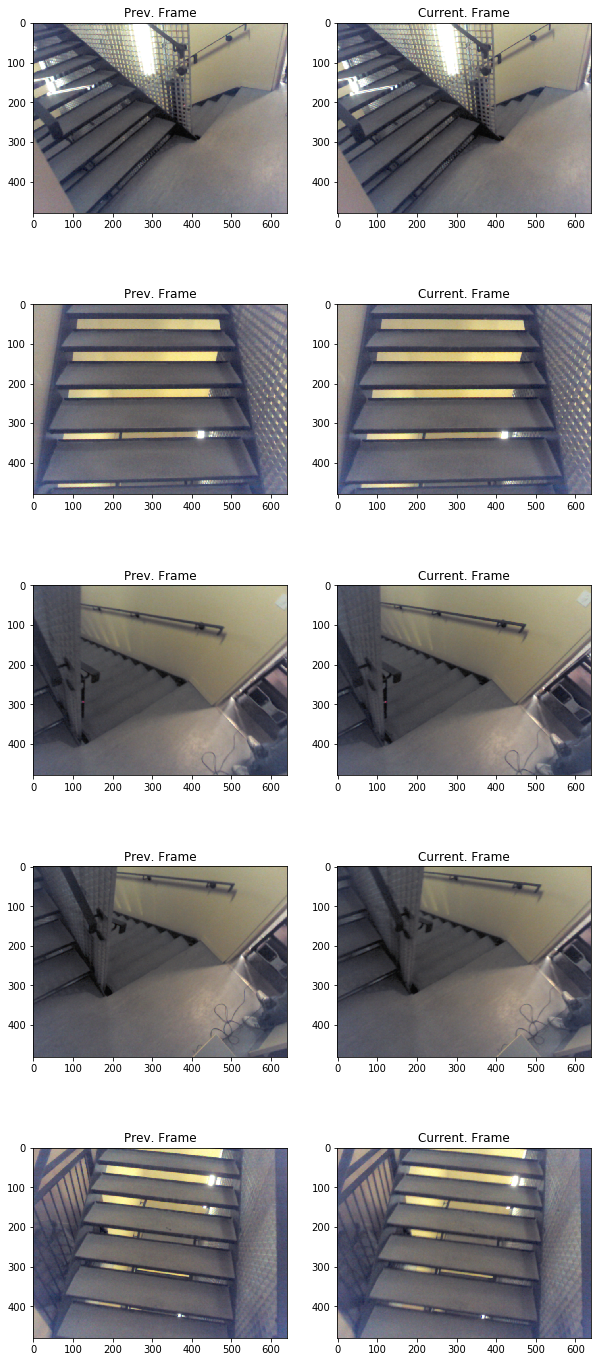

In [19]:
# Number of items to be displayed
display_num = 5

# Randomly selecting the examples from the dataset
random_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, display_num * 5))

for i in range(display_num):
    
    img_num = random_choices[i]

    x_pathname = train_filenames[img_num]

    plt.subplot(display_num,2,2*i+1)  
    plt.imshow(mpimg.imread(x_pathname[0]))
    plt.title("Prev. Frame")

    plt.subplot(display_num,2,2*i+2)
    plt.imshow(mpimg.imread(x_pathname[1]))
    plt.title("Current. Frame")

plt.show()

In [0]:
# Function that performs all the required augmentations
class augment(object):
    
    def __init__(self, scale = 1, img_shape = (640, 480, 3), crop_size = None, random = False):

        self.scale = scale
        self.crop_size = crop_size
        self.random = random
        self.img_shape = img_shape
       
    def zoom(self, image, translation, quarternion):
        
        """Zoom augmentation

        Args:
            image: Image

        Returns:
            Augmented image
        """

        if self.crop_size is not None:
            
            if self.random:
                
                # Generate 20 crop settings, ranging from a 1% to 20% crop.
                scales = list(np.arange(0.8, 1.0, 0.01))
                boxes = np.zeros((len(scales), 4))

                for i, scale in enumerate(scales):
                    x1 = y1 = 0.5 - (0.5 * scale)
                    x2 = y2 = 0.5 + (0.5 * scale)
                    boxes[i] = [x1, y1, x2, y2]

                def random_crop(img):
                    # Create different crops for an image
                    crops = tf.image.crop_and_resize([img], boxes=boxes, box_ind=np.zeros(len(scales)), crop_size=self.crop_size)
                    # Return a random crop
                    return crops[tf.random_uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

                image_0 = random_crop(image[0])
                image_1 = random_crop(image[1])
                
                image = [image_0 , image_1]

                # Only apply cropping 70% of the time
                return image, translation, quarternion
            
            else:
                
                offset_height = int((self.img_shape[1] - self.crop_size[1])//2)
                offset_width = int((self.img_shape[0] - self.crop_size[0])//2)
                target_height = self.crop_size[1]
                target_width = self.crop_size[0]
                
                image_0 = tf.image.crop_to_bounding_box(image[0], offset_height, offset_width, target_height, target_width)
                image_1 = tf.image.crop_to_bounding_box(image[1], offset_height, offset_width, target_height, target_width)
                
                image = [image_0 , image_1]
                
                return image, translation, quarternion
        
        else:
            return image, translation, quarternion
        
    
    def __call__(self, image, translation, quarternion):
        
            
        image, translation, quarternion = self.zoom(image, translation, quarternion)    
        
       
        image_0 = tf.to_float(image[0]) * self.scale 
        image_1 = tf.to_float(image[1]) * self.scale 
        
        image = [image_0 , image_1]

        return image, translation, quarternion

In [0]:
train_augment = augment(scale = 1/255., img_shape = (640, 480, 3), crop_size = (224,224), random = True)

valid_augment = augment(scale = 1/255., img_shape = (640, 480, 3), crop_size = (224,224), random = False)

In [0]:
def process_filenames(filename, translation, quarternion):
   
    img_str_0 = tf.read_file(filename[0])
    img_str_1 = tf.read_file(filename[1])
    
    image_0 = tf.image.decode_jpeg(img_str_0, channels=3)
    image_1 = tf.image.decode_jpeg(img_str_1, channels=3)
    
    image = [image_0 , image_1]

    return image, translation, quarternion

In [23]:
# Function to create a dataset after data augmentation
def get_dataset(filenames, translations, quarternions, shuffle, batch_size, preprocess_func, name = 'dataset'):
               
    with tf.name_scope(name):    
        
        num_x = len(filenames)

        # Create a dataset from the filenames and labels
        dataset = tf.data.Dataset.from_tensor_slices((filenames, translations, quarternions)) 

        dataset = dataset.map(process_filenames, num_parallel_calls = 5)

        dataset = dataset.map(preprocess_func, num_parallel_calls = 5)


        if shuffle:
            dataset = dataset.shuffle(num_x)

        # It's necessary to repeat our data for all epochs 
        dataset = dataset.repeat().batch(batch_size)

        return dataset

# Prepare training dataset
train_ds = get_dataset(train_filenames, train_translations, train_quarternions, shuffle = False, batch_size = batch_size, preprocess_func = train_augment, name = 'train_dataset')

# Prepare training dataset
valid_ds = get_dataset(valid_filenames, valid_translations, valid_quarternions, shuffle = False, batch_size = batch_size, preprocess_func = valid_augment, name = 'valid_dataset')

W0619 07:28:19.165093 140621434689408 deprecation.py:506] From <ipython-input-20-53ae0f430588>:36: calling crop_and_resize_v1 (from tensorflow.python.ops.image_ops_impl) with box_ind is deprecated and will be removed in a future version.
Instructions for updating:
box_ind is deprecated, use box_indices instead
W0619 07:28:19.210160 140621434689408 deprecation.py:323] From <ipython-input-20-53ae0f430588>:72: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


# Visuslise Training Dataset(randomly cropped images) 

W0619 07:28:19.748030 140621434689408 deprecation.py:323] From <ipython-input-24-d84de17d44ac>:9: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


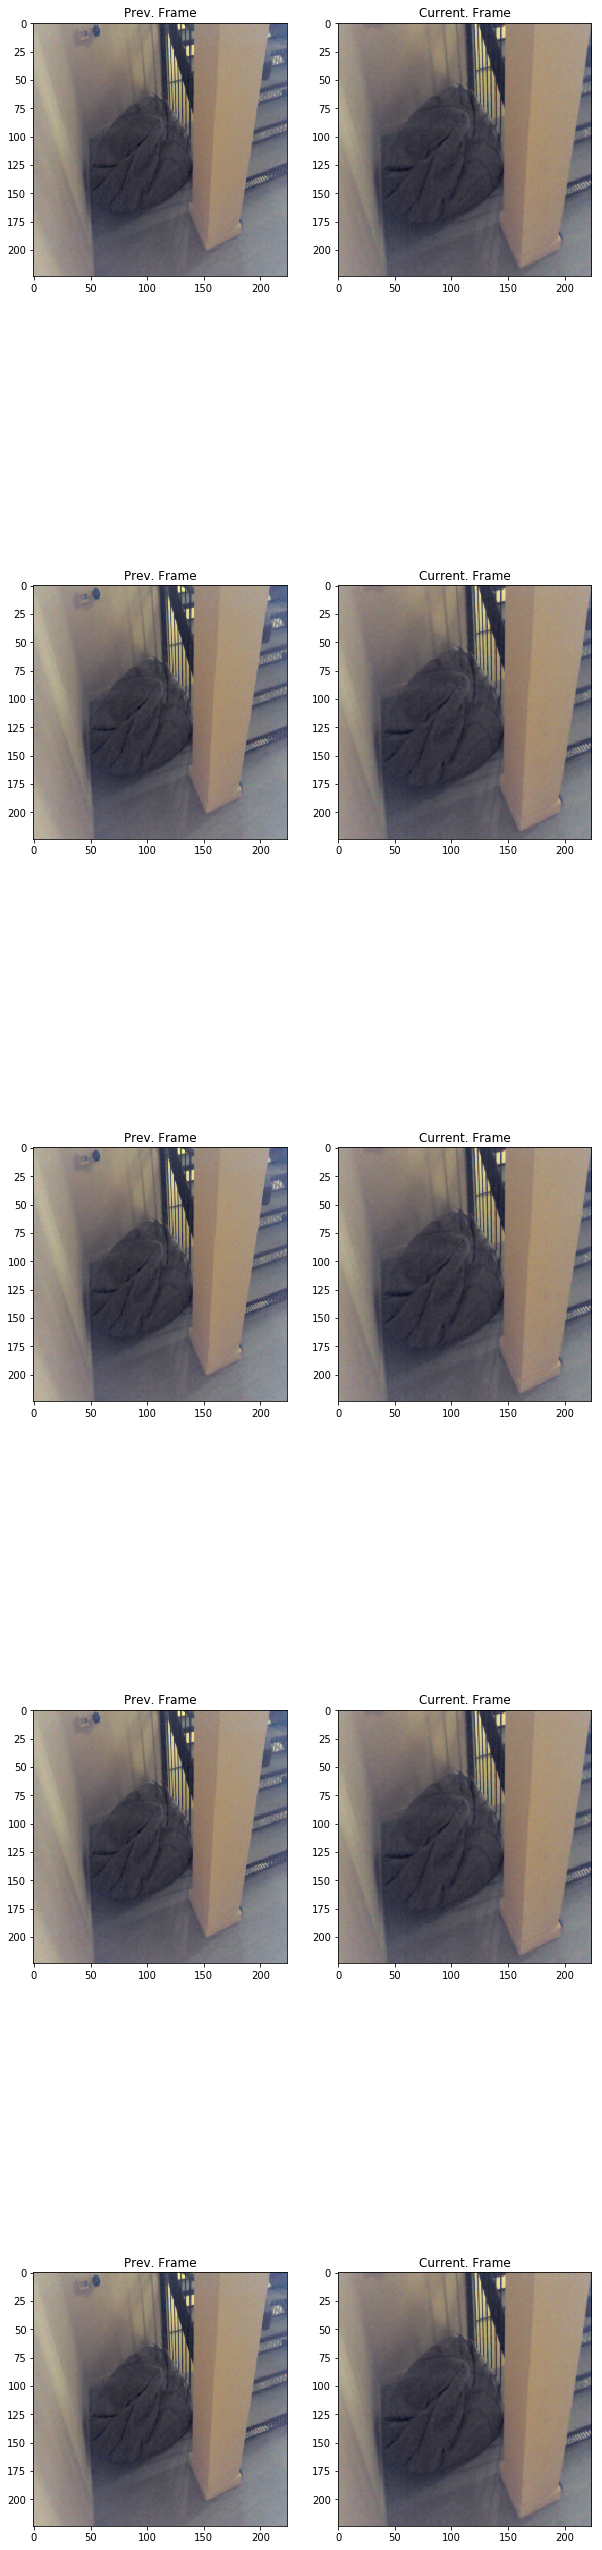

In [24]:
temp_ds = get_dataset(train_filenames, train_translations, train_quarternions, shuffle = False, batch_size = batch_size, preprocess_func = train_augment, name = 'temp_dataset')

display_num = 5

# Randomly selecting the examples from the dataset
random_choices = np.random.choice(batch_size, display_num)

# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce an image since batch size = 1
with tf.Session() as sess: 
    img, translation, quarternion = sess.run(next_element)

    plt.figure(figsize=(10, 10 * display_num))

    for i in range(display_num):

        img_num = random_choices[i]

        plt.subplot(display_num,2,2*i+1)  
        plt.imshow(img[img_num,0,:,:,:])
        plt.title("Prev. Frame")

        plt.subplot(display_num,2,2*i+2)
        plt.imshow(img[img_num,1,:,:,:])
        plt.title("Current. Frame")


# Visualise Validation Dataset (Centre Cropped Images)

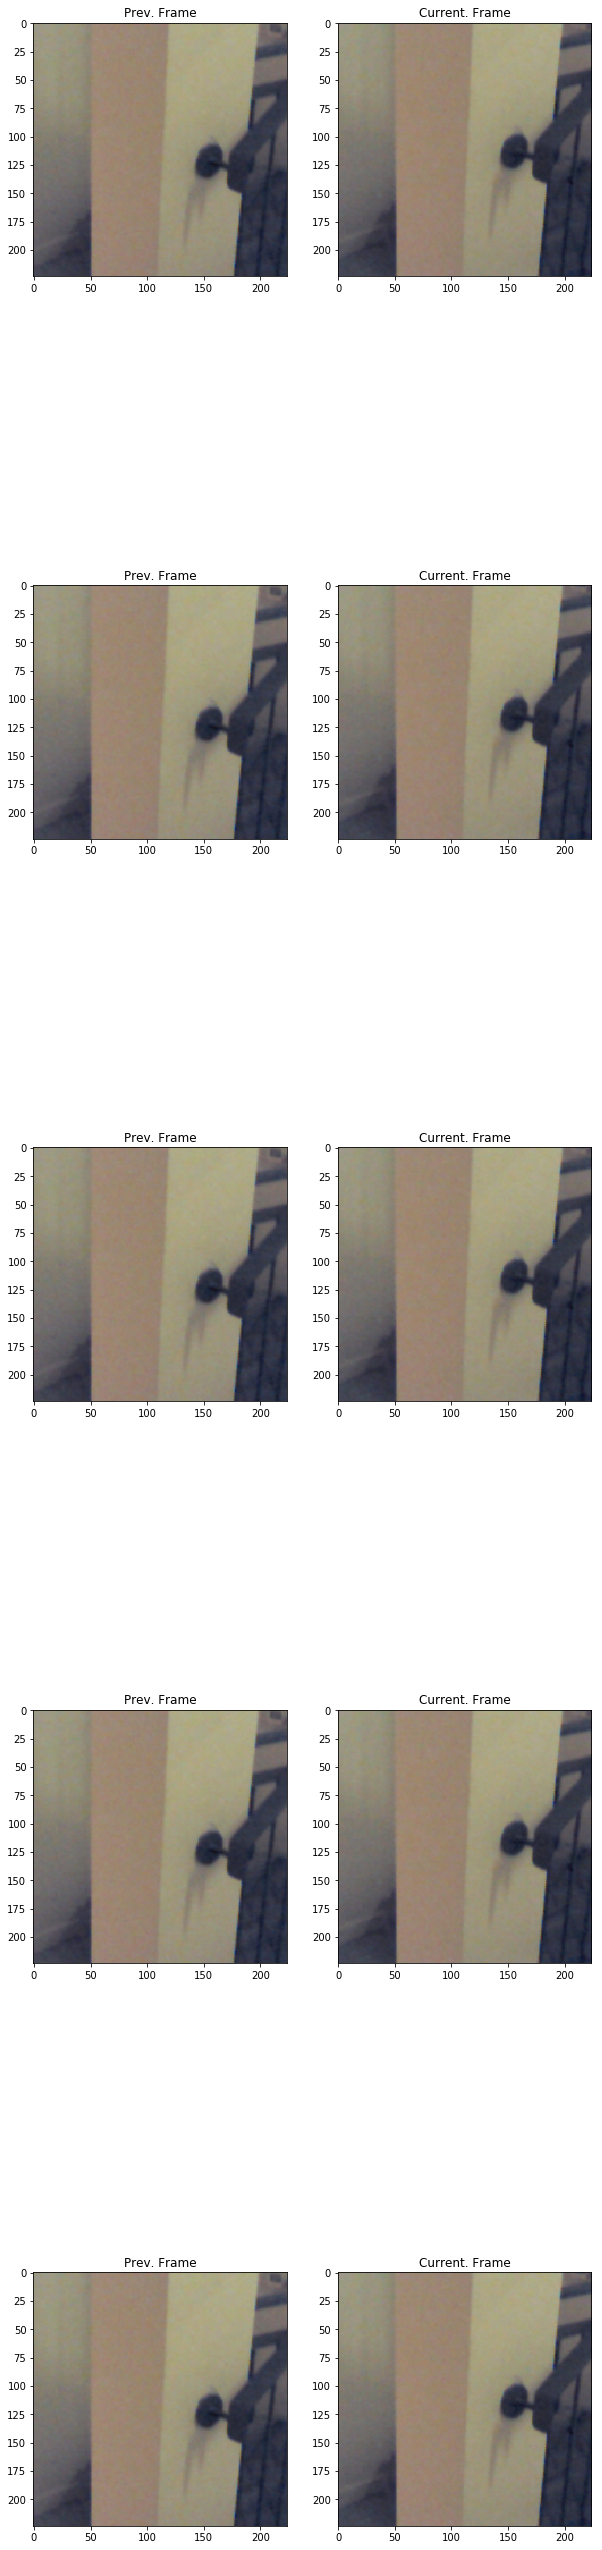

In [25]:
temp_valid_ds = get_dataset(valid_filenames, valid_translations, valid_quarternions, shuffle = False, batch_size = batch_size, preprocess_func = valid_augment, name = 'temp_valid_dataset')

display_num = 5

# Randomly selecting the examples from the dataset
random_choices = np.random.choice(batch_size, display_num)

# Let's examine some of these augmented images
data_aug_iter = temp_valid_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce an image since batch size = 1
with tf.Session() as sess: 
    img, translation, quarternion = sess.run(next_element)

    plt.figure(figsize=(10, 10 * display_num))

    for i in range(display_num):

        img_num = random_choices[i]

        plt.subplot(display_num,2,2*i+1)  
        plt.imshow(img[img_num,0,:,:,:])
        plt.title("Prev. Frame")

        plt.subplot(display_num,2,2*i+2)
        plt.imshow(img[img_num,1,:,:,:])
        plt.title("Current. Frame")


# Load the model

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

_BATCH_NORM_DECAY = 0.997
_BATCH_NORM_EPSILON = 1e-5
DEFAULT_DTYPE = tf.float32
CASTABLE_TYPES = (tf.float16,)
ALLOWED_TYPES = (DEFAULT_DTYPE,) + CASTABLE_TYPES


################################################################################
# Convenience functions for building the ResNet model.
################################################################################
def batch_norm(inputs):

  return tf.compat.v1.layers.batch_normalization(
      inputs=inputs, axis = 3,
      momentum=_BATCH_NORM_DECAY, epsilon=_BATCH_NORM_EPSILON, center=True,
      scale=True, training= True, fused=True)


def fixed_padding(inputs, kernel_size):

  pad_total = kernel_size - 1
  pad_beg = pad_total // 2
  pad_end = pad_total - pad_beg

  padded_inputs = tf.pad(tensor=inputs,
                           paddings=[[0, 0], [pad_beg, pad_end],
                                     [pad_beg, pad_end], [0, 0]])
  return padded_inputs


def conv2d_fixed_padding(inputs, filters, kernel_size, strides):
  """Strided 2-D convolution with explicit padding."""
  # The padding is consistent and is based only on `kernel_size`, not on the
  # dimensions of `inputs` (as opposed to using `tf.layers.conv2d` alone).
  if strides > 1:
    inputs = fixed_padding(inputs, kernel_size)

  return tf.compat.v1.layers.conv2d(
      inputs=inputs, filters=filters, kernel_size=kernel_size, strides=strides,
      padding=('SAME' if strides == 1 else 'VALID'), use_bias=False,
      kernel_initializer=tf.compat.v1.variance_scaling_initializer())


################################################################################
# ResNet block definitions.
################################################################################
def bottleneck_block(inputs, filters, projection_shortcut, strides):
    
  shortcut = inputs

  if projection_shortcut is not None:
    shortcut = projection_shortcut(inputs)
    shortcut = batch_norm(inputs=shortcut)

  inputs = conv2d_fixed_padding(
      inputs=inputs, filters=filters, kernel_size=1, strides=1)
  inputs = batch_norm(inputs)
  inputs = tf.nn.elu(inputs)

  inputs = conv2d_fixed_padding(
      inputs=inputs, filters=filters, kernel_size=3, strides=strides)
  inputs = batch_norm(inputs)
  inputs = tf.nn.elu(inputs)

  inputs = conv2d_fixed_padding(inputs=inputs, filters=4 * filters, kernel_size=1, strides=1)
  inputs = batch_norm(inputs)
    
  inputs += shortcut
  inputs = tf.nn.elu(inputs)

  return inputs

def block_layer(inputs, filters, blocks, strides, name):

  # Bottleneck blocks end with 4x the number of filters as they start with
  filters_out = filters * 4 

  def projection_shortcut(inputs):
    return conv2d_fixed_padding(inputs=inputs, filters=filters_out, kernel_size=1, strides=strides)

  # Only the first block per block_layer uses projection_shortcut and strides
  inputs = bottleneck_block(inputs, filters, projection_shortcut, strides)

  for _ in range(1, blocks):
    inputs = bottleneck_block(inputs, filters, None, 1)

  return tf.identity(inputs, name)


class input_stream(object):

  def __init__(self, num_filters, kernel_size,
               conv_stride, first_pool_size, first_pool_stride,
               block_sizes, block_strides, dtype=DEFAULT_DTYPE, scope_name = 'resnet_model'):

    if dtype not in ALLOWED_TYPES:
      raise ValueError('dtype must be one of: {}'.format(ALLOWED_TYPES))
    
    self.num_filters = num_filters
    self.kernel_size = kernel_size
    self.conv_stride = conv_stride
    self.first_pool_size = first_pool_size
    self.first_pool_stride = first_pool_stride
    self.block_sizes = block_sizes
    self.block_strides = block_strides
    self.dtype = dtype
    self.scope_name = scope_name

  def _custom_dtype_getter(self, getter, name, shape=None, dtype=DEFAULT_DTYPE,
                           *args, **kwargs):

    if dtype in CASTABLE_TYPES:
      var = getter(name, shape, tf.float32, *args, **kwargs)
      return tf.cast(var, dtype=dtype, name=name + '_cast')
    else:
      return getter(name, shape, dtype, *args, **kwargs)

  def _model_variable_scope(self):

    return tf.compat.v1.variable_scope(self.scope_name, custom_getter=self._custom_dtype_getter)

  def __call__(self, inputs):


    with self._model_variable_scope():

      inputs = conv2d_fixed_padding(inputs= inputs, filters=self.num_filters, kernel_size=self.kernel_size, strides=self.conv_stride)
      inputs = tf.identity(inputs, 'initial_conv')
      inputs = batch_norm(inputs)
      inputs = tf.nn.relu(inputs)

      if self.first_pool_size:
        inputs = tf.compat.v1.layers.max_pooling2d(inputs=inputs, pool_size=self.first_pool_size, strides=self.first_pool_stride, padding='SAME')
        inputs = tf.identity(inputs, 'initial_max_pool')
        
      num_filters = self.num_filters * (2**0)
      inputs = block_layer(inputs=inputs, filters=num_filters, blocks=self.block_sizes[0], strides=self.block_strides[0], name='block_layer1')
        
      num_filters = self.num_filters * (2**1)
      pose_inputs = block_layer(inputs=inputs, filters=num_filters, blocks=self.block_sizes[1], strides=self.block_strides[1], name='block_layer2')  
        
      num_filters = self.num_filters * (2**2)
      inputs = block_layer(inputs=pose_inputs, filters=num_filters, blocks=self.block_sizes[2], strides=self.block_strides[2], name='block_layer3')    
        
    return inputs, pose_inputs 

class odometry_stream(object):

  def __init__(self, block_size, block_stride, dtype=DEFAULT_DTYPE, scope_name = 'resnet_model'):

    if dtype not in ALLOWED_TYPES:
      raise ValueError('dtype must be one of: {}'.format(ALLOWED_TYPES))
    
    self.block_size = block_size
    self.block_stride = block_stride
    self.dtype = dtype
    self.scope_name = scope_name

  def _custom_dtype_getter(self, getter, name, shape=None, dtype=DEFAULT_DTYPE,
                           *args, **kwargs):

    if dtype in CASTABLE_TYPES:
      var = getter(name, shape, tf.float32, *args, **kwargs)
      return tf.cast(var, dtype=dtype, name=name + '_cast')
    else:
      return getter(name, shape, dtype, *args, **kwargs)

  def _model_variable_scope(self):

    return tf.compat.v1.variable_scope(self.scope_name, custom_getter=self._custom_dtype_getter)

  def __call__(self, input_1, input_2):
        
    with self._model_variable_scope():    
        
      con = tf.concat([input_1 , input_2], axis = 3)  
      num_filters = int(con.shape[3])    

      inputs = block_layer(inputs=con, filters = num_filters, blocks=self.block_size, strides=self.block_stride, name='block_layer{}'.format(4))
        
      axes = [1, 2]
      inputs = tf.reduce_mean(input_tensor=inputs, axis=axes, keepdims=True)
      inputs = tf.identity(inputs, 'final_reduce_mean')

      flattened = tf.squeeze(inputs, axes)

      inputs = tf.layers.dense(inputs = flattened, units = 1024, kernel_initializer = tf.initializers.glorot_normal(seed = 42))
      position = tf.layers.dense(inputs = inputs, units = 3, kernel_initializer = tf.initializers.glorot_normal(seed = 42))
      orientation = tf.layers.dense(inputs = inputs, units = 4, kernel_initializer = tf.initializers.glorot_normal(seed = 42))

    return position, orientation 

class pose_stream(object):

  def __init__(self, block_sizes, block_strides, dtype=DEFAULT_DTYPE, scope_name = 'resnet_model'):

    if dtype not in ALLOWED_TYPES:
      raise ValueError('dtype must be one of: {}'.format(ALLOWED_TYPES))
    
    self.block_sizes = block_sizes
    self.block_strides = block_strides
    self.dtype = dtype
    self.scope_name = scope_name

  def _custom_dtype_getter(self, getter, name, shape=None, dtype=DEFAULT_DTYPE,
                           *args, **kwargs):

    if dtype in CASTABLE_TYPES:
      var = getter(name, shape, tf.float32, *args, **kwargs)
      return tf.cast(var, dtype=dtype, name=name + '_cast')
    else:
      return getter(name, shape, dtype, *args, **kwargs)

  def _model_variable_scope(self):

    return tf.compat.v1.variable_scope(self.scope_name, custom_getter=self._custom_dtype_getter)

  def __call__(self, pose_inputs_1, position_prev, orientation_prev):
        
    print(position_prev)    
    print(orientation_prev)
        
    feed = tf.concat([position_prev, orientation_prev], axis = 1)   
    
    feed = tf.layers.dense(inputs = feed, units = 14 * 14 * 1024, kernel_initializer = tf.initializers.glorot_normal(seed = 42))
    
    feed = tf.reshape(feed, shape = [-1,14,14,1024])
        
    with self._model_variable_scope():     
        
      num_filters = 64 * (2**2)
      inputs = block_layer(inputs=pose_inputs_1, filters=num_filters, blocks=self.block_sizes[0], strides=self.block_strides[0], name='block_layer3') 
        
      inputs = tf.concat([inputs, feed], axis = -1)  
        
      num_filters = 64 * (2**3)  
      inputs = block_layer(inputs=inputs, filters = num_filters, blocks=self.block_sizes[1], strides=self.block_strides[1], name='block_layer4')
        
      axes = [1, 2]
      inputs = tf.reduce_mean(input_tensor=inputs, axis=axes, keepdims=True)
      inputs = tf.identity(inputs, 'final_reduce_mean')

      flattened = tf.squeeze(inputs, axes)

      inputs = tf.layers.dense(inputs = flattened, units = 1024, kernel_initializer = tf.initializers.glorot_normal(seed = 42))
      position = tf.layers.dense(inputs = inputs, units = 3, kernel_initializer = tf.initializers.glorot_normal(seed = 42))
      orientation = tf.layers.dense(inputs = inputs, units = 4, kernel_initializer = tf.initializers.glorot_normal(seed = 42))

    return position, orientation 

stream_1 = input_stream(num_filters = 64, kernel_size = 7, conv_stride = 2, first_pool_size = 3, first_pool_stride = 2, block_sizes = [3,4,6], block_strides =[1,2,2], scope_name = 'stream_1')

stream_2 = input_stream(num_filters = 64, kernel_size = 7, conv_stride = 2, first_pool_size = 3, first_pool_stride = 2, block_sizes = [3,4,6], block_strides =[1,2,2], scope_name = 'stream_2')

stream_odom = odometry_stream(block_size = 3, block_stride = 2, scope_name = 'odom_stream')

stream_pose = pose_stream(block_sizes = [6,3], block_strides = [2,2], scope_name = 'pose_stream')


In [27]:
with tf.name_scope("Placeholders"):    
    handle = tf.placeholder(tf.string, shape=[])   
    
# create initializable iterators from the dataset
train_iterator = train_ds.make_initializable_iterator()
valid_iterator = valid_ds.make_initializable_iterator() 
    
iterator = tf.data.Iterator.from_string_handle(handle, train_ds.output_types, train_ds.output_shapes)
next_element = iterator.get_next()
frames, position_true, orientation_true = next_element

input_1, pose_inputs_1 = stream_1(frames[:,0,:,:,:])
input_2, pose_inputs_2 = stream_2(frames[:,1,:,:,:])

odom_position_pred, odom_orientation_pred = stream_odom(input_1, input_2)
pose_position_pred, pose_orientation_pred = stream_pose(pose_inputs_2, position_true[:,0], orientation_true[:,0])

W0619 07:28:27.732066 140621434689408 deprecation.py:323] From <ipython-input-27-e7a4ec1aad3e>:5: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
W0619 07:28:27.751355 140621434689408 deprecation.py:323] From <ipython-input-27-e7a4ec1aad3e>:8: DatasetV1.output_types (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
W0619 07:28:27.752406 140621434689408 deprecation.py:323] From <ipython-input-27-e7a4ec1aad3e>:8: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a 

Tensor("strided_slice_2:0", shape=(?, 3), dtype=float32)
Tensor("strided_slice_3:0", shape=(?, 4), dtype=float32)


# Restore the model

In [28]:
variable_1= tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='stream_1')
variable_2=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='stream_2')
variable_odom=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='odom_stream')

saver_1 = tf.train.Saver(variable_1[:len(variable_1)])
saver_2 = tf.train.Saver(variable_2[:len(variable_2)])

with tf.Session() as sess:
    
  sess.run(tf.global_variables_initializer())

  # Restore variables from disk.
  saver_1.restore(sess, latest_ckp_1)
  saver_2.restore(sess, latest_ckp_2)  

  print("Model restored.")    

W0619 07:28:37.773860 140621434689408 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Model restored.


# Print all the tensors in the graph

In [29]:
graph = tf.get_default_graph()

tensors = tf.contrib.graph_editor.get_tensors(tf.get_default_graph())

for idx, tensor in enumerate(tensors):
    print('Index: {}'.format(idx) + '   Tensor: {}'.format(tensors[idx]))

Index: 0   Tensor: Tensor("train_dataset/tensors/normalize_tensors/component_0:0", shape=(2499, 2), dtype=string)
Index: 1   Tensor: Tensor("train_dataset/tensors/normalize_tensors/component_1:0", shape=(2499, 2, 3), dtype=float32)
Index: 2   Tensor: Tensor("train_dataset/tensors/normalize_tensors/component_2:0", shape=(2499, 2, 4), dtype=float32)
Index: 3   Tensor: Tensor("train_dataset/TensorSliceDataset:0", shape=(), dtype=variant)
Index: 4   Tensor: Tensor("train_dataset/num_parallel_calls:0", shape=(), dtype=int32)
Index: 5   Tensor: Tensor("train_dataset/ParallelMapDataset:0", shape=(), dtype=variant)
Index: 6   Tensor: Tensor("train_dataset/num_parallel_calls_1:0", shape=(), dtype=int32)
Index: 7   Tensor: Tensor("train_dataset/ParallelMapDataset_1:0", shape=(), dtype=variant)
Index: 8   Tensor: Tensor("train_dataset/count:0", shape=(), dtype=int64)
Index: 9   Tensor: Tensor("train_dataset/RepeatDataset:0", shape=(), dtype=variant)
Index: 10   Tensor: Tensor("train_dataset/batch

# View Trainable Variables

In [30]:
graph = tf.get_default_graph()

variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

print('Total Number of Variables: {}'.format(len(variables)))

for idx, variable in enumerate(variables):
    print('Index: {}'.format(idx) + '   Variable: {}'.format(variable))

Total Number of Variables: 389
Index: 0   Variable: <tf.Variable 'stream_1/conv2d/kernel:0' shape=(7, 7, 3, 64) dtype=float32_ref>
Index: 1   Variable: <tf.Variable 'stream_1/batch_normalization/gamma:0' shape=(64,) dtype=float32_ref>
Index: 2   Variable: <tf.Variable 'stream_1/batch_normalization/beta:0' shape=(64,) dtype=float32_ref>
Index: 3   Variable: <tf.Variable 'stream_1/conv2d_1/kernel:0' shape=(1, 1, 64, 256) dtype=float32_ref>
Index: 4   Variable: <tf.Variable 'stream_1/batch_normalization_1/gamma:0' shape=(256,) dtype=float32_ref>
Index: 5   Variable: <tf.Variable 'stream_1/batch_normalization_1/beta:0' shape=(256,) dtype=float32_ref>
Index: 6   Variable: <tf.Variable 'stream_1/conv2d_2/kernel:0' shape=(1, 1, 64, 64) dtype=float32_ref>
Index: 7   Variable: <tf.Variable 'stream_1/batch_normalization_2/gamma:0' shape=(64,) dtype=float32_ref>
Index: 8   Variable: <tf.Variable 'stream_1/batch_normalization_2/beta:0' shape=(64,) dtype=float32_ref>
Index: 9   Variable: <tf.Variab

# Define Loss and Optimizer

In [31]:
with tf.name_scope("Loss"):    
    # Defining the loss function
    
    pose_position_loss = tf.sqrt(tf.losses.mean_squared_error(labels = position_true[:,1], predictions = pose_position_pred)) 
    pose_orientation_loss = tf.sqrt(tf.losses.mean_squared_error(labels = orientation_true[:,1], predictions = pose_orientation_pred))     
    
    odom_position_loss = tf.sqrt(tf.losses.mean_squared_error(labels = position_true[:,1]-position_true[:,0], predictions = odom_position_pred)) 
    odom_orientation_loss = tf.sqrt(tf.losses.mean_squared_error(labels = orientation_true[:,1]-orientation_true[:,0], predictions = odom_orientation_pred))  
    
    v1 = tf.get_variable('v1',[1])
    v2 = tf.get_variable('v2',[1])
    
    geometric_loss = tf.exp(-v1) * (pose_position_loss + odom_position_loss) + v1 + tf.exp(-v2) * (pose_orientation_loss + odom_orientation_loss) + v2
    geometric_loss = tf.abs(geometric_loss[0])

with tf.name_scope("Optimizer"):
    # Defining the optimization function
    optimizer_1 = tf.train.AdamOptimizer(learning_rate = 0.000001).minimize(geometric_loss, var_list = variables[258:])  # optimize only the last 6 trainable weights
    optimizer_2 = tf.train.AdamOptimizer(learning_rate = 0.0000001).minimize(geometric_loss, var_list = variables[258:])  # optimize only the last 6 trainable weights
    optimizer_3 = tf.train.AdamOptimizer(learning_rate = 0.00000001).minimize(geometric_loss, var_list = variables)  # optimize only the last 6 trainable weights

with tf.name_scope("Initializer"):    
    # Defining the variable initialisation function
    init = tf.global_variables_initializer()

W0619 07:28:41.716225 140621434689408 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [32]:
graph = tf.get_default_graph()

variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

print('Total Number of Variables: {}'.format(len(variables)))

for idx, variable in enumerate(variables):
    print('Index: {}'.format(idx) + '   Variable: {}'.format(variable))

Total Number of Variables: 391
Index: 0   Variable: <tf.Variable 'stream_1/conv2d/kernel:0' shape=(7, 7, 3, 64) dtype=float32_ref>
Index: 1   Variable: <tf.Variable 'stream_1/batch_normalization/gamma:0' shape=(64,) dtype=float32_ref>
Index: 2   Variable: <tf.Variable 'stream_1/batch_normalization/beta:0' shape=(64,) dtype=float32_ref>
Index: 3   Variable: <tf.Variable 'stream_1/conv2d_1/kernel:0' shape=(1, 1, 64, 256) dtype=float32_ref>
Index: 4   Variable: <tf.Variable 'stream_1/batch_normalization_1/gamma:0' shape=(256,) dtype=float32_ref>
Index: 5   Variable: <tf.Variable 'stream_1/batch_normalization_1/beta:0' shape=(256,) dtype=float32_ref>
Index: 6   Variable: <tf.Variable 'stream_1/conv2d_2/kernel:0' shape=(1, 1, 64, 64) dtype=float32_ref>
Index: 7   Variable: <tf.Variable 'stream_1/batch_normalization_2/gamma:0' shape=(64,) dtype=float32_ref>
Index: 8   Variable: <tf.Variable 'stream_1/batch_normalization_2/beta:0' shape=(64,) dtype=float32_ref>
Index: 9   Variable: <tf.Variab

 # Restore weights and train the model

In [0]:
train_steps = int(np.ceil(num_train_examples / float(batch_size)))
valid_steps = int(np.ceil(num_val_examples / float(batch_size)))

tf.get_default_graph()

saver_1 = tf.train.Saver(variable_1[:len(variable_1)])
saver_2 = tf.train.Saver(variable_2[:len(variable_2)])

with tf.Session() as sess:
    
    # Initialise the variables
    sess.run(init)
    
    # define the train and test handles (before training)
    train_handle = sess.run(train_iterator.string_handle())
    valid_handle = sess.run(valid_iterator.string_handle())
    
    # initialise both the iterators (before training)
    sess.run(train_iterator.initializer)
    sess.run(valid_iterator.initializer)
    
    # Restore variables from disk.
    saver_1.restore(sess, latest_ckp_1)
    saver_2.restore(sess, latest_ckp_2)
    
    optimizers = [optimizer_1, optimizer_2, optimizer_3]
    epochs = [7,10,10]
    
    for i, optimizer in enumerate(optimizers):
        
        print('##################### Optimization: {} #####################'.format(i+1))
    
        for epoch in range(epochs[i]):

            loss_train = 0
            loss_valid = 0

            for step in range(train_steps):

                # Train our model on the batch of data
                loss_train_step , _ = sess.run([geometric_loss, optimizer], feed_dict = {handle: train_handle})
                loss_train += loss_train_step

            for step in range(valid_steps):

                loss_valid_step = sess.run(geometric_loss, feed_dict = {handle: valid_handle})
                loss_valid += loss_valid_step

            loss_train /= train_steps    
            loss_valid /= valid_steps

            print ("Epoch " + str(epoch+1) + ", Train Loss= " + "{:.2f}".format(loss_train) + ", Valid Loss= " + "{:.2f}".format(loss_valid))         